In [2]:
!pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable


In [60]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
molecular_biology_splice_junction_gene_sequences = fetch_ucirepo(id=69) 
  
# data (as pandas dataframes) 
X = molecular_biology_splice_junction_gene_sequences.data.features 
y = molecular_biology_splice_junction_gene_sequences.data.targets 
  
# metadata 
print(molecular_biology_splice_junction_gene_sequences.metadata) 
  
# variable information 
print(molecular_biology_splice_junction_gene_sequences.variables) 


{'uci_id': 69, 'name': 'Molecular Biology (Splice-junction Gene Sequences)', 'repository_url': 'https://archive.ics.uci.edu/dataset/69/molecular+biology+splice+junction+gene+sequences', 'data_url': 'https://archive.ics.uci.edu/static/public/69/data.csv', 'abstract': 'Primate splice-junction gene sequences (DNA) with associated imperfect domain theory', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Sequential', 'Domain-Theory'], 'num_instances': 3190, 'num_features': 60, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': ['instancename'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1991, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5M888', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Problem Description: \r\n      \r\nSplice junctions are points on a DNA sequence at which `superfluous\' DNA is removed during the process of protein creation in

2025-04-11 10:30:12,023 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.866
2025-04-11 10:30:25,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8663883089770354, best pos: [16.40765961  0.63275755  1.78797964]


最优参数组合（n_neighbors, weights_flag, p）： [16.40765961  0.63275755  1.78797964]
验证集准确率： 0.8663883089770354


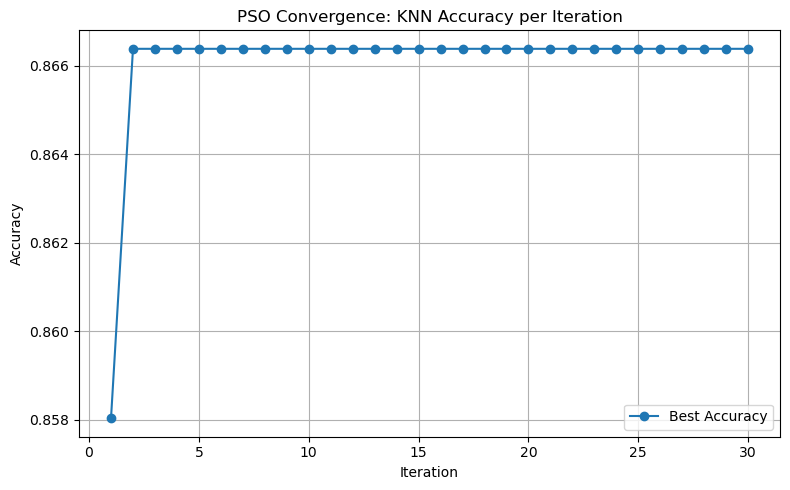


📋 Test Set Classification Report (PSO-KNN):
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       115
           1       0.75      0.98      0.85       115
           2       0.99      0.76      0.86       249

    accuracy                           0.86       479
   macro avg       0.85      0.90      0.86       479
weighted avg       0.89      0.86      0.86       479

AUC Score (PSO-KNN, macro, ovr): 0.9824

📋 Test Set Classification Report (Vanilla KNN):
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       115
           1       0.70      0.90      0.79       115
           2       0.98      0.64      0.77       249

    accuracy                           0.78       479
   macro avg       0.78      0.83      0.78       479
weighted avg       0.83      0.78      0.78       479

AUC Score (Vanilla-KNN, macro, ovr): 0.9570


In [64]:
# ✅ 第一步：数据预处理（读取并编码 DNA 序列）
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# One-hot 编码
def encode_sequence(seq):
    mapping = {'A': [1, 0, 0, 0, 0],
               'C': [0, 1, 0, 0, 0],
               'G': [0, 0, 1, 0, 0],
               'T': [0, 0, 0, 1, 0],
               'N': [0, 0, 0, 0, 1]}
    return np.array([mapping.get(base, [0,0,0,0,0]) for base in seq]).flatten()

def preprocess_ucirepo_data(X_df, y_df):
    sequences = X_df.values.tolist()
    encoded_seqs = np.array([encode_sequence(seq) for seq in sequences])
    labels = LabelEncoder().fit_transform(y_df.values.ravel())
    # stratify + shuffle 更稳妥
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        encoded_seqs, labels, test_size=0.15, random_state=42, shuffle=True, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.1765, random_state=42, shuffle=True, stratify=y_trainval)
    return X_train, X_val, X_test, y_train, y_val, y_test

# 使用 fetch_ucirepo 读取数据
from ucimlrepo import fetch_ucirepo
splice = fetch_ucirepo(id=69)
X_df = molecular_biology_splice_junction_gene_sequences.data.features 
y_df = molecular_biology_splice_junction_gene_sequences.data.targets 
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_ucirepo_data(X_df, y_df)

# ✅ 第二步：定义 KNN 的目标函数（供 PSO 使用）
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def knn_objective_function(params, X_train, y_train, X_val, y_val):
    n_neighbors = int(params[0])
    weights = 'uniform' if int(round(params[1])) == 0 else 'distance'
    p = int(round(params[2]))

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    return -acc

# ✅ 第三步：PSO 设置和封装
from pyswarms.single.global_best import GlobalBestPSO

bounds = (
    [1, 0, 1],
    [30, 1, 2]
)

optimizer = GlobalBestPSO(
    n_particles=10,
    dimensions=3,
    options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
    bounds=bounds
)

history = []

def wrapped_knn_obj(particles):
    results = []
    for param_set in particles:
        loss = knn_objective_function(param_set, X_train, y_train, X_val, y_val)
        results.append(loss)
    best_acc = -min(results)
    history.append(best_acc)
    return np.array(results)

# ✅ 第四步：运行 PSO
best_cost, best_pos = optimizer.optimize(wrapped_knn_obj, iters=30)
print("最优参数组合（n_neighbors, weights_flag, p）：", best_pos)
print("验证集准确率：", -best_cost)

# ✅ 第五步：绘制收敛曲线
import matplotlib.pyplot as plt

def plot_accuracy_trend(history):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(history)+1), history, marker='o', label='Best Accuracy')
    plt.title("PSO Convergence: KNN Accuracy per Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_accuracy_trend(history)

# ✅ 第六步：用最优参数在 test set 上进行最终评估
best_neighbors = int(best_pos[0])
best_weights = 'uniform' if int(round(best_pos[1])) == 0 else 'distance'
best_p = int(round(best_pos[2]))

final_model = KNeighborsClassifier(n_neighbors=best_neighbors, weights=best_weights, p=best_p)
final_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))
y_pred = final_model.predict(X_test)

print("\n📋 Test Set Classification Report (PSO-KNN):")
print(classification_report(y_test, y_pred))

# 计算 AUC
classes = list(set(y_test))
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_prob = final_model.predict_proba(X_test)
auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
print(f"AUC Score (PSO-KNN, macro, ovr): {auc:.4f}")

# ✅ 第七步：单独构建一个未优化的 KNN 模型用于对比
vanilla_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)
vanilla_knn.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))
y_pred_vanilla = vanilla_knn.predict(X_test)

print("\n📋 Test Set Classification Report (Vanilla KNN):")
print(classification_report(y_test, y_pred_vanilla))

# AUC for vanilla KNN
vanilla_prob = vanilla_knn.predict_proba(X_test)
auc_vanilla = roc_auc_score(y_test_bin, vanilla_prob, average='macro', multi_class='ovr')
print(f"AUC Score (Vanilla-KNN, macro, ovr): {auc_vanilla:.4f}")
